In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import CubicSpline
from scipy import optimize

We need to find the policy functions of the following problem:

$$V(z, a; w, r) = \max_{a^{\prime}} \left\{ U(z - a^{\prime}) + \beta \Pi(z^{\prime}|z)V(z^{\prime}, a; w,r)\right\}$$

$$ \text{sa : } z^{\prime} = w l^{\prime} + (1+r) a^{\prime}$$

But we know that since the borrowing limit is zero, we can rewrite the problem as:

$$V(l, a; w, r) = \max_{a^{\prime}} \left\{ U(w l + (1+r) a - a^{\prime}) + \beta \sum_{l^{\prime}}\Pi(l^{\prime}|l)V(l^{\prime}, a^{\prime}; w,r)\right\}$$

where:




In [2]:
# Define Parameters:

n_a = 80        # Grids for Assets.
n_l = 19        # Markov States or labor.
α = 0.4        # Capital Share.
ρ = 0.95        # Memory of labor (Standard deviation).
σ = 0.0645      # Volatility of labor .
δ = 1           # Depreciation.
β = 0.96        # Discont factor.
θ = 1.5           # Expanding grid parameter.
error = 10e-6   # Error tolerance.
max_iter = 1000
λ = (1-β)/β                    # Impatience parameter.

# Construct the markov chain using rouwenhorst method:

markov = qe.markov.approximation.rouwenhorst(n = n_l, ybar = 0, sigma = σ, rho= ρ)

# Create the transition matrix:
# Element (i,j) is the probability of being in state l_i and going to l_j.
# Each row gives the probability of switching states given where we are.

Π = markov.P   

### Finding the stationary distribution:

for n in range(1000):

    if n == 0:

        π = Π[0,:].copy()

    else:

        π = π @ Π

# Create the vector for income shocks:

L = np.exp(markov.state_values)

# Compute the stationary demand supply:

L_bar = π @ L

# Compute the capital in the neoclassical growth model:

K_ng = (((λ + 1)/α)**(1/(α-1))) * L_bar  # Capital in the neoclassical growth model.

# Asset grid:

A_max = 5.0
A_min = 0.0

A = A_min + (A_max - A_min) * (np.linspace(0, 1, n_a)**θ)



### On the assumptions of impatience vs the interest rate.

C:\Users\belmu\AppData\Local\Temp\ipykernel_21336\2161082120.py:2: RuntimeWarning: divide by zero encountered in power
  ax.plot(np.linspace(0, 1, 100), α * np.linspace(0, 1, 100)**(α-1) - 1, 'r', label = 'r')


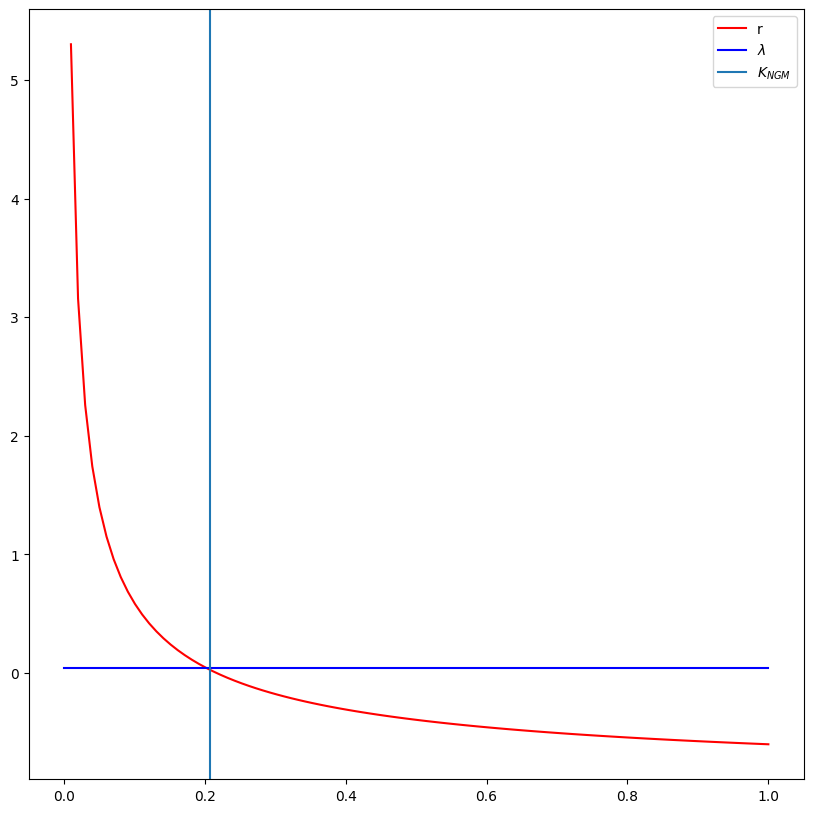

In [3]:
fig, ax  = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0, 1, 100), α * np.linspace(0, 1, 100)**(α-1) - 1, 'r', label = 'r')
ax.plot(np.linspace(0, 1, 100) , np.linspace(0, 1, 100) * 0 + λ, 'b', label = r'$\lambda$')
ax.axvline(K_ng, label = r'$K_{NGM}$')
plt.legend()
plt.show()

In [4]:
### Parameters and initial conditions:

γ = 2

# Capital level, this will pin down prices and capital suppply:
# K should always be above 141, else agents will save infinit amounts.

K = K_ng
r_k = α * (K/L_bar)**(α-1)
r = r_k - δ
w = (1-α) * (K)**(α) * (L_bar)**(-α)

# Initial conditions:

# Initial value function.
# We need something increasing and concave therefore we can use U(z[i,j]):
V_0 = np.empty((n_l, n_a), dtype = float)
V_1 = np.empty((n_l, n_a), dtype = float)

for i in range(n_l):

    z = w * L[i] + (1 + r) * A
    V_0[i,:] = U(z, γ) 

# Policy for assets: 

h_0 = np.zeros((n_l, n_a), dtype=float)
h_1 = h_0.copy()

In [5]:
iter = 0

while iter < max_iter:

    for i in range(n_l):
        # Interpolate the value function given income realization:
        E_V  = scipy.interpolate.PchipInterpolator(A, Π[i,:] @ V_0, extrapolate = True)
        for j in range(n_a):
            # Given labor income and assets wealth is given by:
            z = w * L[i] + (1 + r) * A[j]
            # return function:
            def R(x):
                return -(U(z - x, γ) + β * E_V(x))  
            bounds_A = scipy.optimize.Bounds(A[0], np.minimum(z, A[-1])) 
            x_0 = 0.5 * (A[0]+np.minimum(z, A[-1]))         
            h_1[i, j] = scipy.optimize.minimize(R, x_0, tol = error, method = 'SLSQP', bounds = bounds_A).x[0]
            V_1[i,j] = (U(z - h_1[i, j], γ) + β * E_V(h_1[i, j]))
        
    error_i = np.amax(np.abs((h_1 - h_0)/(1 + np.abs(h_0))))

    if error_i < error:

        print("Solution Found")
        print(f'Iterations', iter)
        print(f'Error', error_i)
        break
    
    else:
        if iter % 100 == 0:
            print("Entering iteration")
            print(iter)
            print("Error")
            print('{0:.16f}'.format(error_i))
            
        V_0 = np.copy(V_1)
        h_0 = np.copy(h_1)
        iter += 1
        if iter >= max_iter:
            print("No solution")

Entering iteration
0
Error
2.5667187652930084


C:\Users\belmu\AppData\Local\Temp\ipykernel_21336\3865258096.py:59: RuntimeWarning: divide by zero encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))


KeyboardInterrupt: 

In [ ]:
## Assets:

fig, ax  = plt.subplots(3, figsize=(10,10))
for i in range(n_l):
    ax[0].plot(A, V_1[i,:])
    ax[1].plot(A[0:10], h_1[0,:10])
    ax[2].plot(A, h_1[i,:])
plt.show()

In [ ]:
class Ayiagari:

    def __init__(self, n_a = 60, n_l = 19, α = 0.7, γ = 2, δ =1, ρ = 0.95, β = 0.96
                     , σ = 0.0645, θ = 3, A_min = 0, A_max = 4,   error = 10e-6, max_iter = 1000):

        self.n_a = n_a                 # Grids for Assets.
        self.n_l = n_l                 # Markov States or labor.
        self.α = α                     # Capital Share.
        self.ρ = ρ                     # Memory of labor (Standard deviation).
        self.σ = σ                     # Volatility of labor .
        self.δ = δ                     # Depreciation.
        self.β = β                     # Discont factor.
        self.θ = θ                     # Expanding grid parameter.
        self.error = 10e-6             # Error tolerance.
        self.max_iter = 1000           # Max iterations.
        self.A_min = A_min             # Minimum assets.
        self.A_max = A_max             # Maximum assets.
        
        # Create the transition matrix:
        # Element (i,j) is the probability of being in state l_i and going to l_j.
        # Each row gives the probability of switching states given where we are
        
        markov = qe.markov.approximation.rouwenhorst(n = n_l, ybar = 0, sigma = σ, rho= ρ)

        self.Π = markov.P   
        for n in range(1000):
            if n == 0:
                self.π =  self.Π[0,:].copy()
            else:
                self.π = self.π @ self.Π
        self.π = self.π

        # Create the vector for income shocks:
        # Compute the stationary demand supply:

        self.L = np.exp(markov.state_values)
        self.L_bar = self.π @ self.L
        self.A = A_min + (A_max - A_min) * (np.linspace(0, 1, n_a)**θ)

        
        self.params = n_a, n_l, α, δ, β, γ, self.L_bar, A_min, A_max
        self.grids = self.Π, self.π, self.A, self.L

In [ ]:
# Utility function

def U(c, γ):
    return (1/(1-γ)) * ((c)**(1-γ))

In [ ]:
Ayiagari_1 = Ayiagari()

In [ ]:
def VFI_Agent(model, K):

    # Unload parameters:

    error = model.error 
    max_iter = model.max_iter
    n_a, n_l, α, δ, β, γ, L_bar, A_min, A_max = model.params
    Π, π, A, L = model.grids

    # Aux. variables:

    iter = 0
    bounds_A = scipy.optimize.Bounds(A[0], A[-1])

    # Prices:

    r_k = α * (K/L_bar)**(α-1)
    r = r_k - δ
    w = (1-α) * (K)**(α) * (L_bar)**(-α)

    # Initial conditions:

    # Initial value function.
    # We need something increasing and concave therefore we can use U(z[i,j]):
    V_0 = np.empty((n_l, n_a), dtype = float)
    V_1 = np.empty((n_l, n_a), dtype = float)

    for i in range(n_l):

        z = w * L[i] + (1 + r) * A
        V_0[i,:] = U(z, γ) 

    # Policy for assets: 

    h_0 = np.zeros((n_l, n_a), dtype=float)
    h_1 = h_0.copy()
   
    iter = 0

    while iter < max_iter:

        for i in range(n_l):
            # Interpolate the value function given income realization:
            E_V  = scipy.interpolate.PchipInterpolator(A, Π[i,:] @ V_0, extrapolate = True)
            for j in range(n_a):
                # Given labor income and assets wealth is given by:
                z = w * L[i] + (1 + r) * A[j]
                # return function:
                def R(x):
                    return -(U(z - x, γ) + β * E_V(x))  
                bounds_A = scipy.optimize.Bounds(A[0], np.minimum(z, A[-1])) 
                x_0 = 0.5 * (A[0]+np.minimum(z, A[-1]))         
                h_1[i, j] = scipy.optimize.minimize(R, x_0, tol = error, method = 'SLSQP', bounds = bounds_A).x[0]
                V_1[i,j] = (U(z - h_1[i, j], γ) + β * E_V(h_1[i, j]))
            
        error_i = np.amax(np.abs((h_1 - h_0)/(1 + np.abs(h_0))))

        if error_i < error:

            print("Solution Found")
            print(f'Iterations', iter)
            print(f'Error', error_i)
            break
        
        else:
            if iter % 100 == 0:
                print("Entering iteration")
                print(iter)
                print("Error")
                print('{0:.16f}'.format(error_i))
                
            V_0 = np.copy(V_1)
            h_0 = np.copy(h_1)
            iter += 1
            if iter >= max_iter:
                print("No solution")

    return V_1, h_1    